# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

The project folder has the following structure:

* In the main directory you have this notebook, `cnn_from_scratch.ipynb`, that contains the instruction and some questions you will have to answer. Follow this notebook and complete the required sections in order.

* In the `src/` directory you have several source files. As instructed in this notebook, you will open and complete those files, then come back to this notebook to execute some tests that will verify what you have done. While these tests don't guarantee that your work is bug-free, they will help you finding the most obvious problems so you will be able to proceed to the next step with confidence.

* Sometimes you will need to restart the notebook. If you do so, remember to execute also the cells containing the code you have already completed starting from the top, before you move on.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust your intuition.  And, of course, have fun!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [ ]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [ ]:
%load_ext autoreload
%autoreload 2 

Important! After you have ran pip install, please restart the kernel using the **Kernel** menu 

In [ ]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data

In this and the following steps we are going to complete some code, and then execute some tests to make sure the code works as intended. 

Open the file `src/data.py`. It contains a function called `get_data_loaders`. Read the function and complete all the parts marked by `YOUR CODE HERE`. Once you have finished, test that your implementation is correct by executing the following cell (see below for what to do if a test fails):

In [ ]:
!pip install pytest

In [ ]:
!pip install mlflow

In [ ]:
!pytest -vv src/data.py -k data_loaders

You should see something like:
```
src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 1.81s ========================
```
If all the tests are `PASSED`, you can move to the next section.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> **What to do if tests fail**
When a test fails, `pytest` will mark it as `FAILED` as opposed to `PASSED`, and will print a lot of useful output, including a message that should tell you what the problem is. For example, this is the output of a failed test:
> ```
>    def test_data_loaders_keys(data_loaders):
>    
>       assert set(data_loaders.keys()) == {"train", "valid", "test"}
E       AssertionError: assert {'tes', 'train', 'valid'} == {'test', 'train', 'valid'}
E         Extra items in the left set:
E         'tes'
E         Full diff:
E         - {'test', 'train', 'valid'}
E         + {'tes', 'train', 'valid'}
E         ?                          +++++++
>
> src/data.py:171: AssertionError
-------------- Captured stdout setup ----------------------------------------------
Reusing cached mean and std for landmark_images
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
=========== short test summary info ===============================================
FAILED src/data.py::test_data_loaders_keys - AssertionError: The keys of the data_loaders dictionary should be train, valid and test
> ``` 
> In the `short test summary info` you can see a short description of the problem. In this case, the dictionary we are returning has the wrong keys. Going above a little, you can see that the test expects `{'test', 'train', 'valid'}` while we are returning `{'tes', 'train', 'valid'}` (there is a missing `t`). So we can go back to our function, fix that problem and test again.
> 
> In other cases, you might get an error like:
> ```
    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
>                       self.padding, self.dilation, self.groups)
E       RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
>
> ../../../../miniconda3/envs/udacity_starter/lib/python3.7/site-packages/torch/nn/modules/conv.py:440: RuntimeError
> ```
> Looking at the stack trace you should be able to understand what it is going on. In this case, we forgot to add a `.cuda()` to some tensor. For example, the model is on the GPU, but the data aren't.

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
First, the images are cropped to 256x256. Then, they are randomly cropped to 224x224. This size is chosen because 224x224 is a standard image size in machine learning, allowing for efficient training and compatibility with many pre-trained models.

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?



<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: 

Yes, I decided to augment the dataset using RandAugment due to its ease of use and robustness. RandAugment has only two parameters: 'num_ops' and 'magnitude'. 'num_ops' determines the number of transformations applied to each image, while 'magnitude' controls the intensity of these transformations. This simplicity makes it easier to tune compared to adjusting multiple parameters for different transforms, improving the model's generalization by exposing it to a variety of image variations.



### Visualize a Batch of Training Data

Go back to `src/data.py` and complete the function `visualize_one_batch` in all places with the `YOUR CODE HERE` marker. After you're done, execute the following cell and make sure the test `src/data.py::test_visualize_one_batch` is `PASSED`:

In [ ]:
!pytest -vv src/data.py -k visualize_one_batch

We can now use the code we just completed to get a batch of images from your train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

In [ ]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(
        batch_size = 5,
        valid_size = 0.01, 
        num_workers = 2,
        limit =  -1

)# YOUR CODE HERE

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

Open `src/model.py` and complete the `MyModel` class filling in all the `YOUR CODE HERE` sections. After you're done, execute the following test and make sure it passes:

In [ ]:
!pytest -vv src/model.py

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ 



---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer

Open `src/optimization.py` and complete the `get_loss` function, then execute the test and make sure it passes:

In [ ]:
!pytest -vv src/optimization.py -k get_loss

Then, in the same file, complete the `get_optimizer` function then execute its tests, and make sure they all pass:

In [ ]:
!pytest -vv src/optimization.py -k get_optimizer

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions you are completing, so it will help you catching glaring problems but it won't guarantee that your training code is bug-free. If you see that your loss is not decreasing, for example, that's a sign of a bug or of a flawed model design. Use your judgement.

Open `src/train.py` and complete the `train_one_epoch` function, then run the tests:

In [ ]:
!pytest -vv src/train.py -k train_one_epoch

Now complete the `valid` function, then run the tests:

In [ ]:
!pytest -vv src/train.py -k valid_one_epoch

Now complete the `optimize` function, then run the tests:

In [ ]:
!pytest -vv src/train.py -k optimize

Finally, complete the `test` function then run the tests:

In [ ]:
!pytest -vv src/train.py -k one_epoch_test

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. Feel free to experiment with different values and try to optimize your model:

In [1]:
import torch
torch.cuda.empty_cache()

In [18]:
"""
batch_size = 256      # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.20       # fraction of the training data to reserve for validation
num_epochs = 50 #50       # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.20 #0.4          # dropout for our model
learning_rate = 0.001   #0.001  # Learning rate for SGD (or Adam)
opt = 'ADAM'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.003  # regularization. Increase this to combat overfitting
"""

"\nbatch_size = 256      # size of the minibatch for stochastic gradient descent (or Adam)\nvalid_size = 0.20       # fraction of the training data to reserve for validation\nnum_epochs = 50 #50       # number of epochs for training\nnum_classes = 50       # number of classes. Do not change this\ndropout = 0.20 #0.4          # dropout for our model\nlearning_rate = 0.001   #0.001  # Learning rate for SGD (or Adam)\nopt = 'ADAM'            # optimizer. 'sgd' or 'adam'\nweight_decay = 0.003  # regularization. Increase this to combat overfitting\n"

In [10]:
import torch
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import torch.optim as optim
import copy
import matplotlib.pyplot as plt 


In [4]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel


/opt/conda/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
def lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders):
    
    # Save initial weights so we can restore them at the end
    torch.save(model.state_dict(), "__weights_backup")
    
    # specify optimizer
    optimizer = optim.SGD(model.parameters(), lr=min_lr)

    # We create a learning rate scheduler that increases the learning
    # rate at every batch.
    # Find the factor where min_lr r**(n_steps-1) = max_lr
    r = np.power(max_lr / min_lr, 1 / (n_steps - 1))

    def new_lr(epoch):
        """
        This should return the *factor* by which the initial learning
        rate must be multipled for to get the desired learning rate
        """
        return r ** epoch

    # This scheduler increases the learning rate by a constanct factor (r)
    # at every iteration
    lr_scheduler = LambdaLR(optimizer, new_lr)

    # Set the model in training mode
    # (so all layers that behave differently between training and evaluation,
    # like batchnorm and dropout, will select their training behavior)
    model.train()

    # Loop over the training data
    losses = {}
    train_loss = 0.0

    for batch_idx, (data, target) in tqdm(
        enumerate(data_loaders["train"]),
        desc="Training",
        total=len(data_loaders["train"]),
        leave=True,
        ncols=80,
    ):
        # move data to GPU if available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        # 1. clear the gradients of all optimized variables
        optimizer.zero_grad()  # -
        # 2. forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)  # =
        # 3. calculate the loss
        loss_value = loss(output, target)  # =
        # 4. backward pass: compute gradient of the loss with respect to model parameters
        loss_value.backward()  # -
        # 5. perform a single optimization step (parameter update)
        optimizer.step()  # -

        train_loss = train_loss + (
            (1 / (batch_idx + 1)) * (loss_value.data.item() - train_loss)
        )

        losses[lr_scheduler.get_last_lr()[0]] = train_loss

        # Stop if the loss gets too big
        if train_loss / min(losses.values()) > 10:
            break

        if batch_idx == n_steps - 1:
            break
        else:
            # Increase the learning rate for the next iteration
            lr_scheduler.step()
    
    # Restore model to its initial state
    model.load_state_dict(torch.load('__weights_backup'))
    
    return losses


### Find Learning Rate 

In [6]:
# get the data loaders using batch_size and valid_size defined in the previous
# cell
data_loaders = get_data_loaders(
    batch_size = batch_size,
    valid_size = valid_size)# YOUR CODE HERE

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model =MyModel(num_classes = num_classes, dropout = dropout)  # YOUR CODE HERE
if torch.cuda.is_available():
    model.cuda()
#print(model)


Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


In [7]:
# Get the loss using get_loss
loss = get_loss() 


Using CUDA while defining the loss function.


In [8]:
# Range  and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(data_loaders['train']), 200)
n_steps


16

Training:  94%|██████████████████████████████▉  | 15/16 [01:21<00:05,  5.41s/it]


(4.000775337219238, 4.036714977771044)

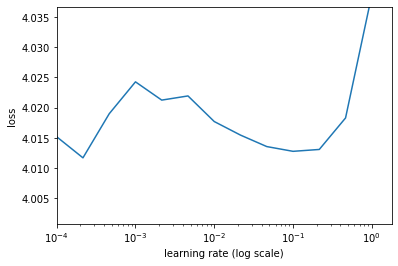

In [11]:

losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

In [12]:
del model

In [27]:
learning_rate =0.001 #(1e-1 - 1e-2)/2


In [29]:
batch_size = 256      # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.20       # fraction of the training data to reserve for validation
num_epochs = 50 #50       # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.20 #0.4          # dropout for our model
print("Learning rate: ", learning_rate)    #0.001  # Learning rate for SGD (or Adam)
opt = 'ADAM'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.005  # regularization. Increase this to combat overfitting

Learning rate:  0.001


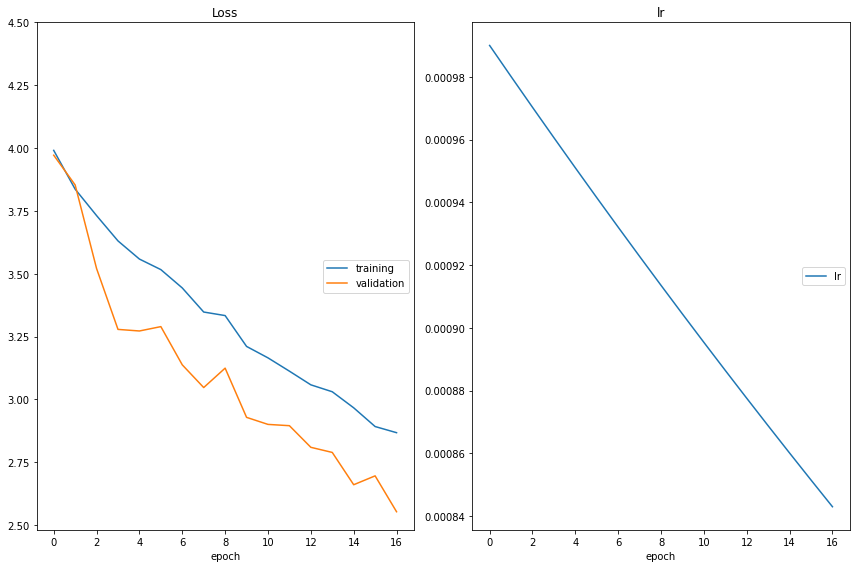

Validating:  25%|████████▎                        | 1/4 [00:04<00:12,  4.10s/it]

In [ ]:

from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
#data_loaders = get_data_loaders(
#        batch_size = batch_size, valid_size = valid_size,)# YOUR CODE HERE

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model =MyModel(num_classes = num_classes, dropout = dropout)  # YOUR CODE HERE
#print(model)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model = model,
    optimizer = opt,
    learning_rate  = learning_rate,
    weight_decay = weight_decay)# YOUR CODE HERE

# Get the loss using get_loss
loss = get_loss() # YOUR CODE HERE

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)


In [ ]:
import mlflow 
from helpers import one_epoch_test

def train_one_model(model,
                    learning_rate,
                    n_epochs,
                    data_loaders,
                    loss,
                    optimizer
                   ):
    
    #transforms = get_transforms(rand_augment_magnitude=rand_augment_magnitude)
    #data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)
    #model = Net()
    
    if torch.cuda.available():
        model.cuda()
    
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    #loss = nn.CrossEntropyLoss()
    
    with mlflow.start_run():
        
        optimize(data_loaders, model, optimizer, loss, n_epochs, "best_val_loss.pt", interactive_tracking=True)
        
        # Restore best validation loss
        model.load_state_dict(torch.load('best_val_loss.pt'))
        
        # Test model on *validation* set (never optimize your hyperparameters on the 
        # test set!)
        val_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)
        
        # Use mlflow.log_param to log the learning rate and the
        # rand_augment_magnitude
        
        # track metrics
        mlflow.log_param("learning_rate", learning_rate)
        #mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        # Use mlflow.log_metric to log your validation loss
        # YOUR CODE HERE
        mlflow.log_metric("val_loss", val_loss)
        
        val_accuracy = (np.array(preds)==np.array(actuals)).sum() / len(actuals)
        
        # Use mlflow to log the validation accuracy as a metric
        # YOUR CODE HERE
        mlflow.log_metric("val_accuracy", val_accuracy)
        
        # Use mlflow.log_artifact to log the best_val_loss.pt file
        mlflow.log_artifact("best_val_loss.pt")

In [ ]:
#model =MyModel(num_classes = num_classes, dropout = dropout)  


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> only run this *after* you have completed hyperpameter optimization. Do not optimize hyperparameters by looking at the results on the test set, or you might overfit on the test set (bad, bad, bad)

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [ ]:
# load the model that got the best validation accuracy
#from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
# Load the state dictionary from the checkpoint file
checkpoint_path = 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run test
one_epoch_test(data_loaders['test'], model, loss)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual, we need to complete some code!

Open `src/predictor.py` and fill up the missing code, then run the tests:

In [ ]:
!pytest -vv src/predictor.py

Allright, now we are ready to export our model using our Predictor class:

In [ ]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

# YOUR CODE HERE
checkpoint_path = 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])

device = torch.device("cpu")
model.to(device)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor) # YOUR CODE HERE

scripted_predictor.save("checkpoints/original_exported.pt")

Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [ ]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt")  # YOUR CODE HERE

In [ ]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

Finally, let's have a look at the confusion matrix of the model we are going to use in production:

In [ ]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)